# 学习笔记：Diffusion and Score-Based Generative Models (未完结)

## 数学基础

### 随机微分方程
考虑一个ode:
$$dX(t)=μ(X(t),t)dt$$
这时，我们可以通过加入一个带系数的噪声项来将其转化为一个随机微分方程：
$$\downarrow \text{加入高斯噪声} dW(t)\sim N(0,dt)$$
$$dX(t)=μ(X(t),t)dt+σ(X(t),t)dW(t)$$
这时 $X(t)$ 表示一个随机过程，$\mu$ 和 $\sigma$ 不带有随机性。

考虑一个简单的SDE（布朗运动）:
$$dX(t)=dW(t)$$
取时间步长为1时则有 $X(t+1) - X(t) \sim N(0,1)$

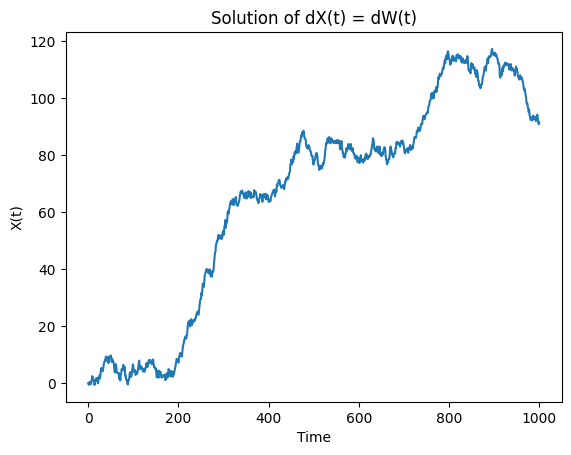

In [20]:
import numpy as np
import matplotlib.pyplot as plt
def brownian_motion():
    T = 1000  # 总时间
    N = 1000  # 步数
    dt = T / N  # 时间步长

    # 模拟布朗运动
    X = np.zeros(N)
    for i in range(1, N):
        X[i] = X[i - 1] + np.sqrt(dt) * np.random.normal()

    # 绘制图像
    t = np.linspace(0, T, N)
    plt.plot(t, X)
    plt.xlabel('Time')
    plt.ylabel('X(t)')
    plt.title('Solution of dX(t) = dW(t)')
    plt.show()

brownian_motion()

### 朗之万动力学
Langevin 动力学描述的是例子在势能场中的运动，可以把损失函数视为一个势能场，因此：
$$dX(t)=\overbrace{\nabla [-\log p(x)]}^{得分函数}+\sqrt{2D}dW(t)$$

得分函数：可以描述概率的变化率，并且求梯度后可以消掉归一化常数项，使我们在不知道具体分布函数但了解分布概率相对大小的情况下，仍可以求解。

_Langevin 动力学示例_

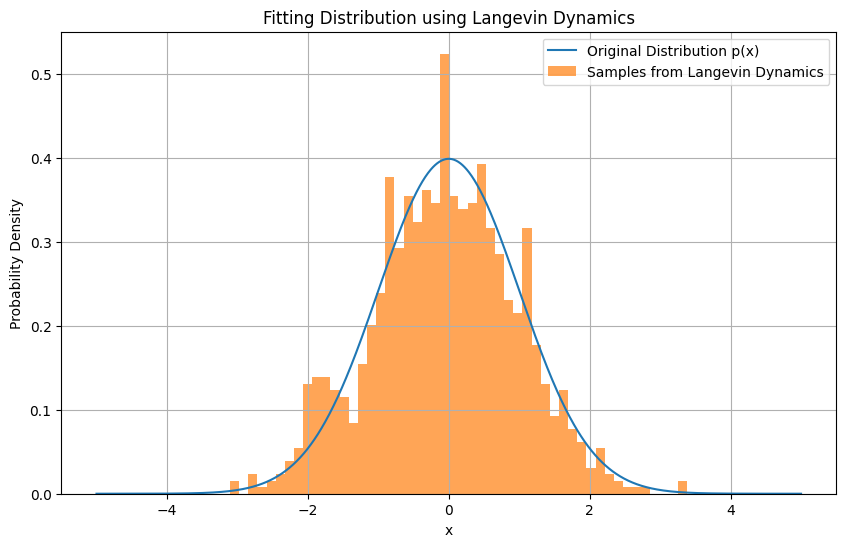

In [21]:
from scipy.stats import norm

# 定义目标分布 p(x)，这里以标准正态分布为例
def target_distribution(x):
    return norm.pdf(x, loc=0, scale=1)

# 计算目标分布的对数概率的梯度
def log_prob_gradient(x):
    # 对于标准正态分布，对数概率的梯度为 -x
    return -x

# 朗之万动力学采样
def langevin_dynamics(num_samples, num_steps, step_size):
    samples = np.zeros((num_samples, num_steps))
    # 初始化样本
    samples[:, 0] = np.random.normal(size=num_samples)
    for i in range(num_samples):
        for t in range(1, num_steps):
            # 朗之万动力学更新规则
            noise = np.random.normal()
            samples[i, t] = samples[i, t - 1] + 0.5 * step_size * log_prob_gradient(samples[i, t - 1]) + np.sqrt(step_size) * noise
    return samples[:, -1]

# 参数设置
num_samples = 1000  # 采样的样本数量
num_steps = 1000    # 迭代步数
step_size = 0.1     # 步长

# 进行朗之万动力学采样
samples = langevin_dynamics(num_samples, num_steps, step_size)

# 绘制原始分布和采样得到的分布
x = np.linspace(-5, 5, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, target_distribution(x), label='Original Distribution p(x)')
plt.hist(samples, bins=50, density=True, alpha=0.7, label='Samples from Langevin Dynamics')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Fitting Distribution using Langevin Dynamics')
plt.legend()
plt.grid(True)
plt.show()

Langevin 动力学的思想：利用梯度函数引导样本向高概率区域移动，同时避免陷入局部最优（因为有随机项的存在，粒子不会被锁死在一个地方），以及避免在低概率区域的拟合效果过差。

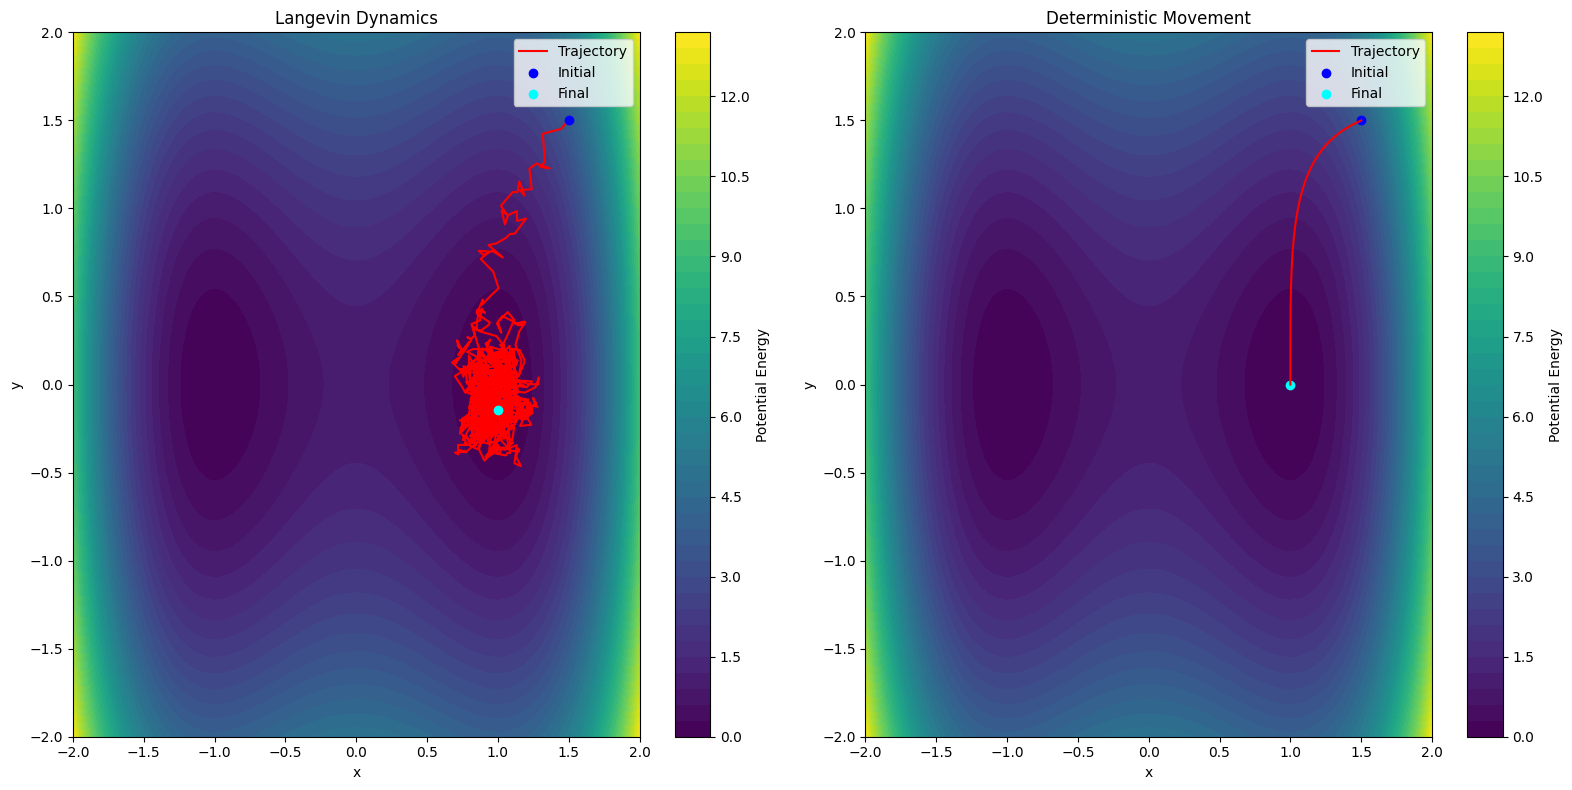

In [22]:

# 定义势能场函数
def potential(x, y):
    return (x**2 - 1)**2 + y**2

# 计算势能场的梯度
def gradient(x, y, h=1e-5):
    dx = (potential(x + h, y) - potential(x - h, y)) / (2 * h)
    dy = (potential(x, y + h) - potential(x, y - h)) / (2 * h)
    return np.array([dx, dy])

# Langevin 动力学模拟
def langevin_dynamics(num_steps, dt, gamma, kT, initial_position):
    positions = [initial_position]
    current_position = np.array(initial_position, dtype=np.float64)

    for _ in range(num_steps):
        grad = gradient(*current_position)
        noise = np.random.normal(0, np.sqrt(2 * kT * gamma * dt), 2)
        current_position = current_position - dt * grad / gamma + noise
        positions.append(current_position)
    return np.array(positions)

# 确定性移动模拟（仅按梯度）
def deterministic_movement(num_steps, dt, gamma, initial_position):
    positions = [initial_position]
    current_position = np.array(initial_position, dtype=np.float64)

    for _ in range(num_steps):
        grad = gradient(*current_position)
        current_position = current_position - dt * grad / gamma
        positions.append(current_position)
    return np.array(positions)

def Langevin(initial_position = [1.5, 1.5]):
    # 参数设置
    num_steps = 1000
    dt = 0.01
    gamma = 1.0
    kT = 0.1


    # 运行模拟
    langevin_trajectory = langevin_dynamics(num_steps, dt, gamma, kT, initial_position)
    deterministic_trajectory = deterministic_movement(num_steps, dt, gamma, initial_position)

    # 生成势能场网格数据
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = potential(X, Y)

    # 创建两个子图
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 绘制 Langevin 动力学图
    ax1 = axes[0]
    contour1 = ax1.contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(contour1, ax=ax1, label='Potential Energy')
    ax1.plot(langevin_trajectory[:, 0], langevin_trajectory[:, 1], 'r-', label='Trajectory')
    ax1.scatter(langevin_trajectory[0, 0], langevin_trajectory[0, 1], color='blue', marker='o', label='Initial',zorder=3)
    ax1.scatter(langevin_trajectory[-1, 0], langevin_trajectory[-1, 1], color='cyan', marker='o', label='Final', zorder=3)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Langevin Dynamics')
    ax1.legend()

    # 绘制确定性移动图
    ax2 = axes[1]
    contour2 = ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
    fig.colorbar(contour2, ax=ax2, label='Potential Energy')
    ax2.plot(deterministic_trajectory[:, 0], deterministic_trajectory[:, 1], 'r-', label='Trajectory')
    ax2.scatter(deterministic_trajectory[0, 0], deterministic_trajectory[0, 1], color='blue', marker='o', label='Initial')
    ax2.scatter(deterministic_trajectory[-1, 0], deterministic_trajectory[-1, 1], color='cyan', marker='o', label='Final')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Deterministic Movement')
    ax2.legend()

    plt.tight_layout()
    plt.show()
Langevin()

下图展示了朗之万动力学可以避免陷入局部最优解。（起始点梯度为0）

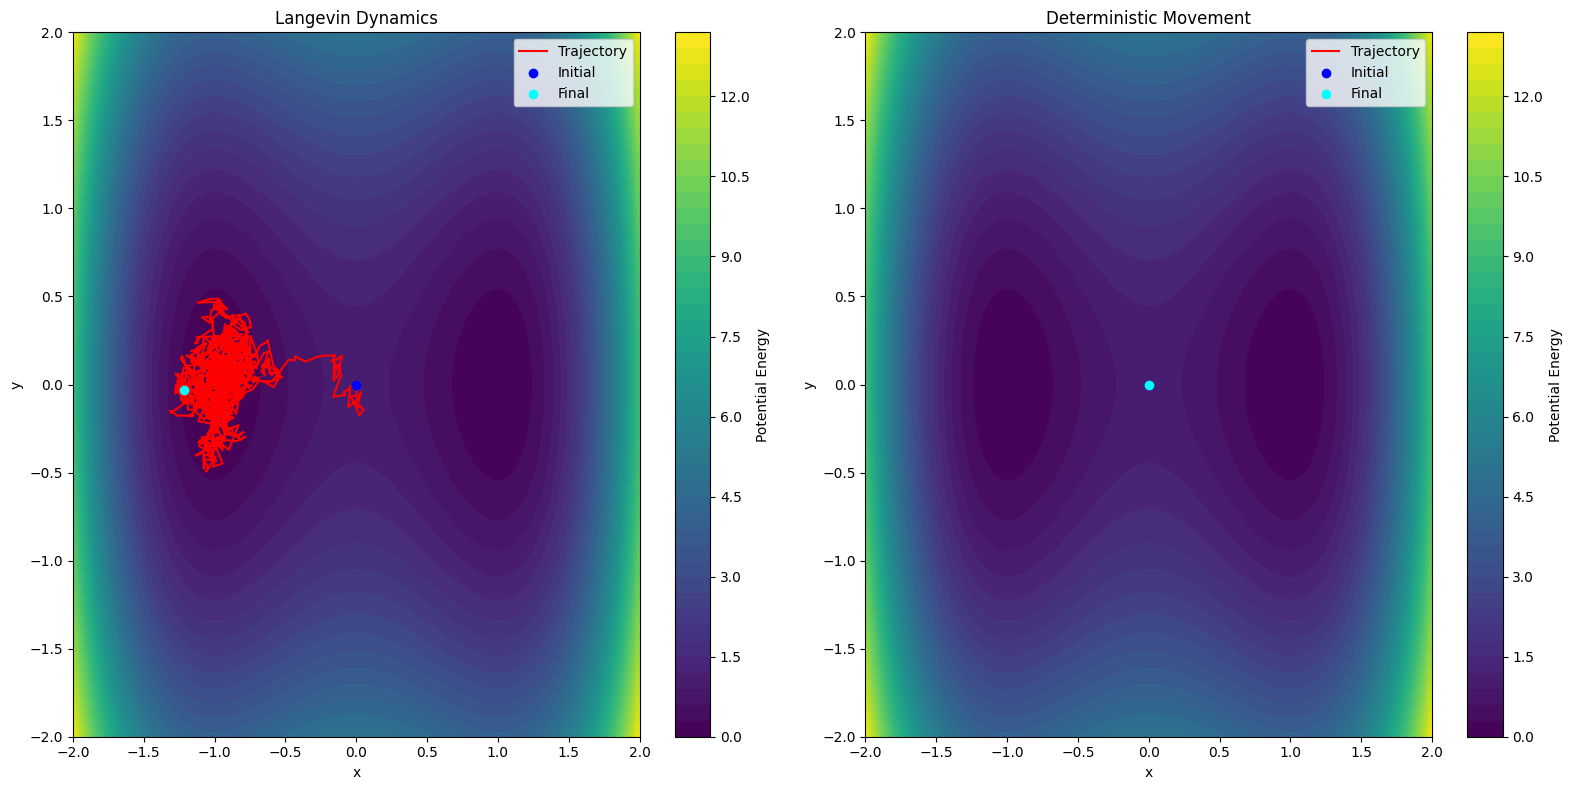

In [23]:
Langevin([0,0])

## 得分函数：建模与训练

在概率建模问题中，我们往往利用一个神经网络的输出 $y$ 来表示各种可能情况对应的概率，即它对应一个概率分布 $p(x)$。然而神经网络的输出值往往是不符合概率论公理的，为了能够使用概率论的方法来分析，就需要对其进行一些变换，使得其符合概率分布的要求。比如归一化常数 $Z$，但是往往计算归一化常数是复杂的，因此对于客观的拟合目标 $p(x)$，定义得分函数
$$s(x) = -\nabla_x \log p(x)$$
该函数保留了 $p(x)$ 的全部信息，并且可以通过神经网络来拟合。由于
$$-\nabla_x \log p(x)=-\nabla_x \log \frac{y(x)}{Z}=-\nabla_x \log y(x)$$
我们可以略去繁杂的归一化常数的计算，从而只需要训练 $s_{\theta}(x)$ 并利用它来生成图像。

得分函数的意义是，其方向是 $x$ 变化最快的方向，y

### 得分匹配

我们可以通过比较 $s(x)$ 和 $s_{\theta}(x)$ 来作为损失函数：（可以理解为求矢量差的平均模长）
$$\frac{1}{2}\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}[\|\underbrace{\nabla_{\mathbf{x}}\log p_{\mathrm{data}}(\mathbf{x})}_{\text{Unknown}}-s_{\boldsymbol{\theta}}(\mathbf{x})\|_{2}^{2}]~~~\text{(Fisher divergence)}$$

为了能够进行计算，采取前人的 __得分匹配__ 算法将上式化为
$$\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}\left[\frac{1}{2}\left\|s_{\theta}(\mathbf{x})\right\|_{2}^{2}+\mathrm{trace}(\underbrace{\nabla_{\mathrm{x}}s_{\theta}(\mathbf{x})}_{\text{Jacobian of }s_{\theta}(\mathbf{x})})\right]\approx\frac{1}{N}\sum_{i=1}^{N}\left[\frac{1}{2}\left\|s_{\theta}(\mathbf{x}_{i})\right\|_{2}^{2}+\mathrm{trace}\left(\nabla_{\mathbf{x}}s_{\theta}(\mathbf{x}_{i})\right)\right]$$
其中 $\text{trace}$ 表示迹。

#### 切片得分匹配 (Sliced Score Matching)
> 在机器学习中 $\mathbb{E}_{x\sim p}[y(x)] := \int_{X}y(x)p(x)\text{d} x$

上面的公式的问题就在于维度越高，在计算迹时需要的反向传播的次数就越多。因此我们采用一种思想：降维。因为如果两个向量彼此靠近，他们在某个直线上的投影也会非常接近。
$$\frac{1}{2}\mathbb{E}_{p_{\mathbf{v}}}\mathbb{E}_{p_{\mathrm{data}}(\mathbf{x})}[(\mathbf{v}^\intercal\nabla_\mathbf{x}\log p_{\mathrm{data}}(\mathbf{x})-\mathbf{v}^\intercal\mathrm{s}_\theta(\mathbf{x}))^2]$$

接下来展开平方项：
$$=\frac{1}{2}\mathbb{E}\left[(\mathbf{v}^\intercal\nabla\log p_\mathrm{data})^2-2(\mathbf{v}^\intercal\nabla\log p_\mathrm{data})(\mathbf{v}^\intercal s_\theta)+(\mathbf{v}^\intercal s_\theta)^2\right]$$

处理交叉项，利用分部积分：
$$\begin{aligned}&\mathbb{E}_{p_{\mathrm{data}}}\left[\mathbf{v}^\intercal\nabla\log p_{\mathrm{data}}\cdot f(\mathbf{x})\right]\\
&=\int \left[\mathbf{v}^\intercal\nabla\log p_{\mathrm{data}}\cdot f(\mathbf{x})\right]p_{data}(\mathbf{x})d\mathbf{x}~~~\text{(把梯度放进去)}\\
&=\int \mathbf{v}^\intercal\cdot\left[f(\mathbf{x})\right]p_{data}(\mathbf{x})d\log p_{data}(\mathbf{x})\\
&=\underbrace{\mathbf{v}^\intercal\cdot\left[f(\mathbf{x})\right]\log p_{data}(\mathbf{x})p_{data}(\mathbf{x})\mid_{X}}_{\text{根据密度函数在无穷远处趋于0，该项为0}} -\mathbb{E}_{p_{\mathrm{data}}}\left[\mathbf{v}^\intercal\nabla f(\mathbf{x})\right]\\
&=-\mathbb{E}_{p_{\mathrm{data}}}\left[\mathbf{v}^\intercal\nabla f(\mathbf{x})\right]
\end{aligned}$$

代入原式，并忽略掉与 $\theta$ 无关的项，根据 $\nabla \mathbf{v}^\intercal s_{\theta}(\mathbf{x})=\nabla [s_{\theta}(\mathbf{x})] \mathbf{v}  $ 有：
$$\mathbb{E}_{p_{\mathbf{v}}} \mathbb{E}_{p_{\text{data}}} \left[ \mathbf{v}^\top \nabla_{\mathbf{x}} s_\theta \mathbf{v} + \frac{1}{2} \left( \mathbf{v}^\top s_\theta \right)^2 \right]$$
__这是我们新的损失函数__，其中 $\mathbf{v}$ 是一个随机向量，通常取正态分布或均匀分布。相比于直接计算迹，这个只需要在完成前向传播后计算一步向量内积，再在反向传播后计算一次向量内积。一共就多了两步。

#### 去噪得分匹配 (Denoising Score Matching)
参考 [知乎回答](https://www.zhihu.com/question/487904648/answer/3057023165) 我们将目标变为去除噪声。

## 生成模型

### 朗之万动力学采样 (Langevin Dynamics Sampling)

如何从得分函数中获得样本呢？一种想法是从得分函数（一个势能场）中采样，然后利用梯度下降将样本点（粒子）引导到高概率值的点。
为了防止样本点全部收敛到一处，我们引入维纳过程项，即朗之万随机微分方程。

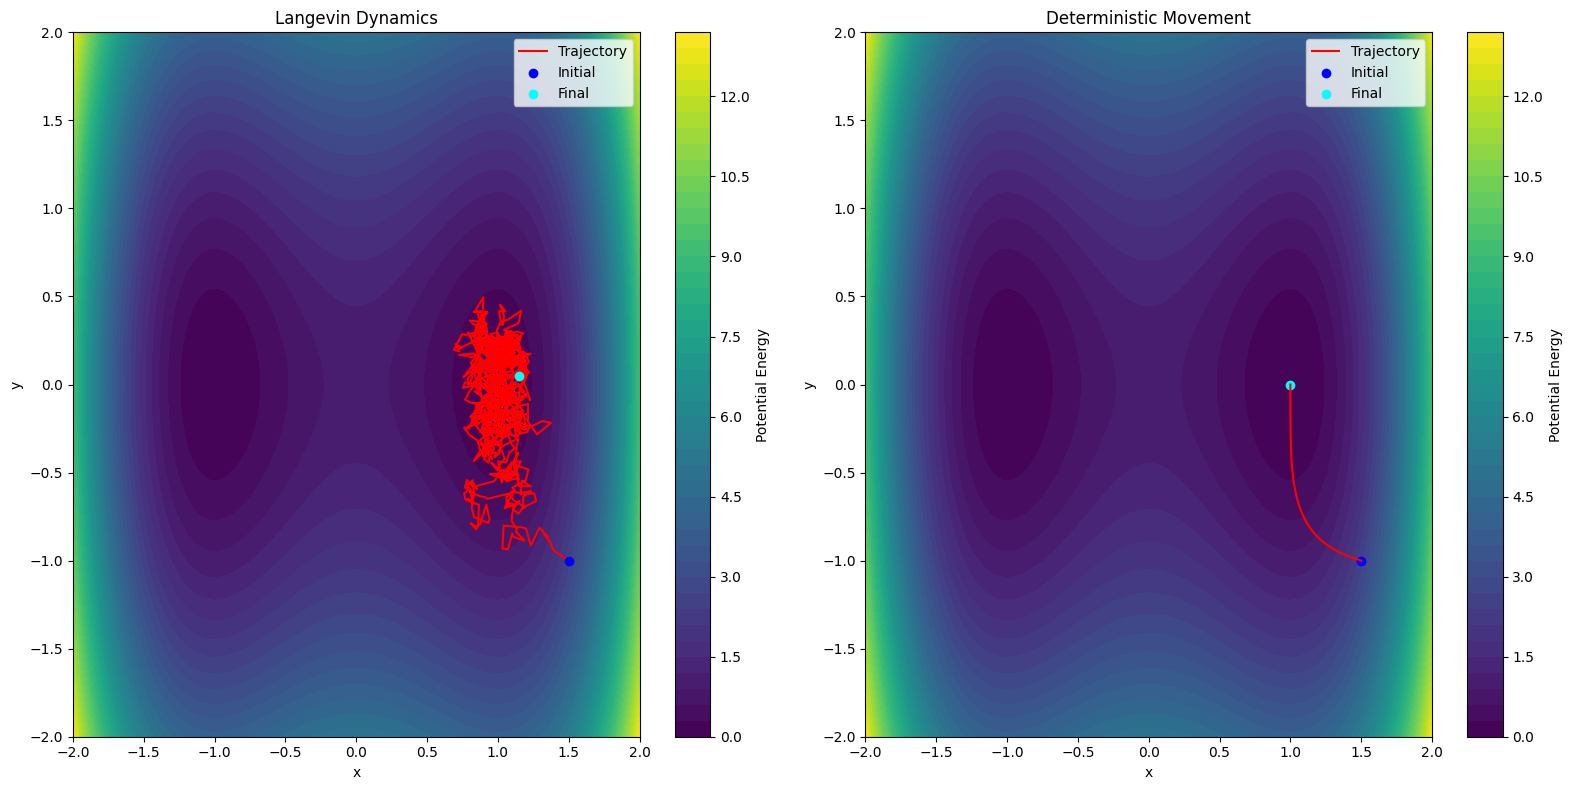

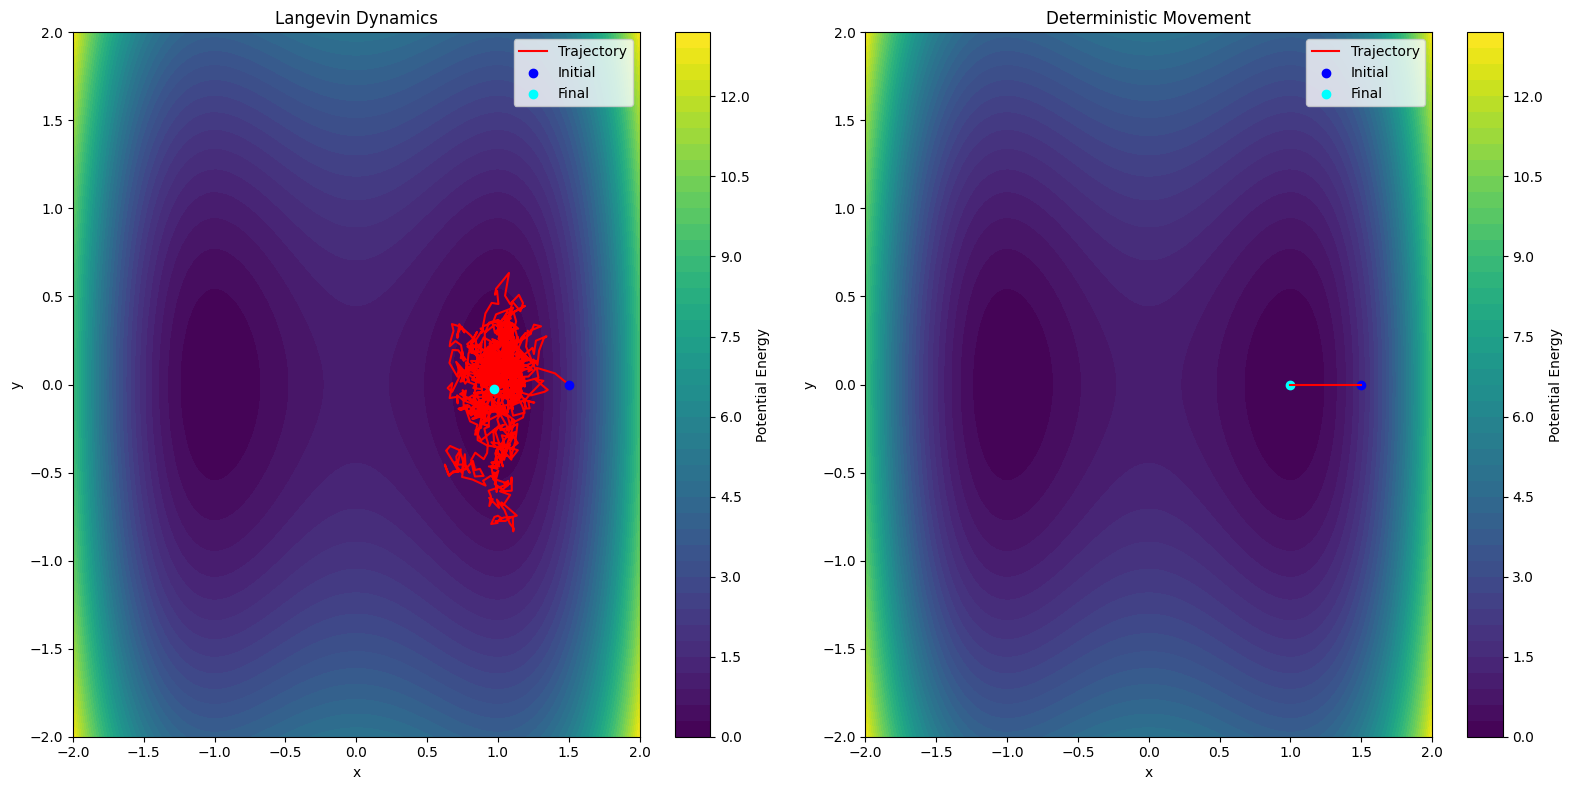

In [24]:
Langevin([1.5,-1])
Langevin([1.5,0])

然而仅仅这样是不够的，因为得分函数

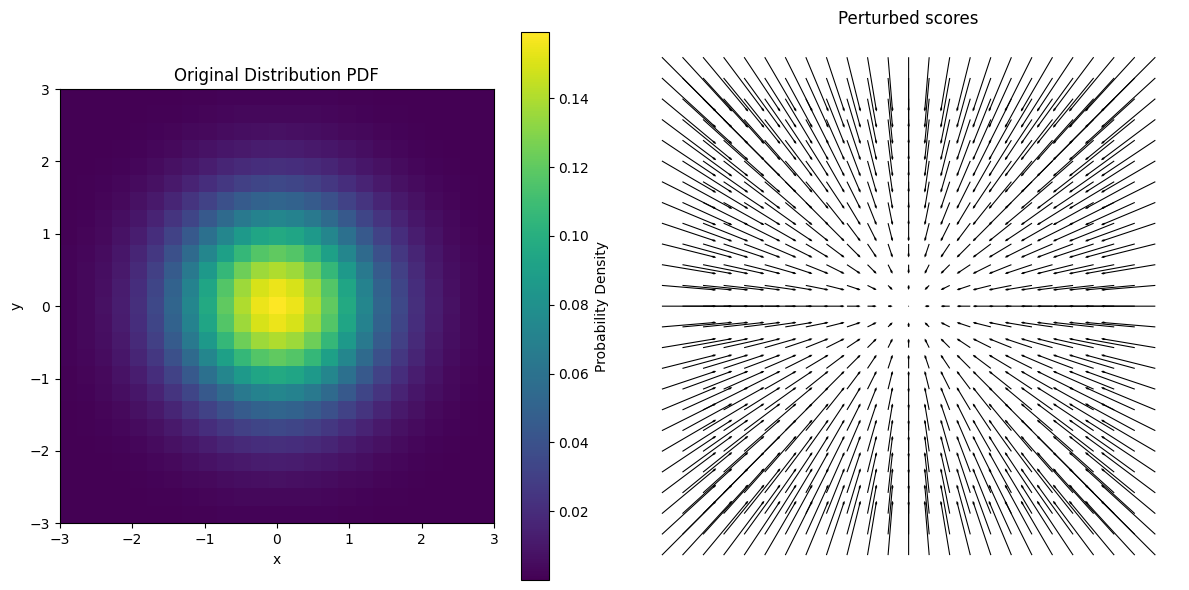

In [25]:
# 定义二维正态分布参数（示例参数）
mu_x, mu_y = 0, 0
sigma_x, sigma_y = 1, 1
rho = 0

# 减少网格点数，让图像更简洁
x = np.linspace(-3, 3, 25)
y = np.linspace(-3, 3, 25)
X, Y = np.meshgrid(x, y)

# 计算二维正态分布的概率密度函数
z_x = (X - mu_x) / sigma_x
z_y = (Y - mu_y) / sigma_y
denom = 1 - rho ** 2
exponent = -0.5 / denom * (z_x ** 2 - 2 * rho * z_x * z_y + z_y ** 2)
pdf = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(denom)) * np.exp(exponent)

# 计算梯度（得分函数）
L_x = - (z_x - rho * z_y) / (sigma_x * denom)
L_y = - (z_y - rho * z_x) / (sigma_y * denom)

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 绘制原始分布概率密度函数的热力图
im = axes[0].imshow(pdf, cmap='viridis', origin='lower', extent=[-3, 3, -3, 3])
axes[0].set_title('Original Distribution PDF', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
fig.colorbar(im, ax=axes[0], label='Probability Density')

# 绘制简洁箭头图
# 调整箭头样式：更细、颜色深灰
q = axes[1].quiver(X, Y, L_x, L_y,
                   scale=30,  # 调整箭头长度比例
                   color='black',
                   width=0.002,  # 箭头线宽更细
                   headwidth=2,  # 箭头头部更小
                   headlength=2)
axes[1].set_title('Perturbed scores', fontsize=12)
axes[1].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

C:\Users\29600\AppData\Local\Temp\ipykernel_28096\1504517551.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_x[i, j] = (kde(point_plus_hx) - kde(point_minus_hx)) / (2 * h)
C:\Users\29600\AppData\Local\Temp\ipykernel_28096\1504517551.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  grad_y[i, j] = (kde(point_plus_hy) - kde(point_minus_hy)) / (2 * h)


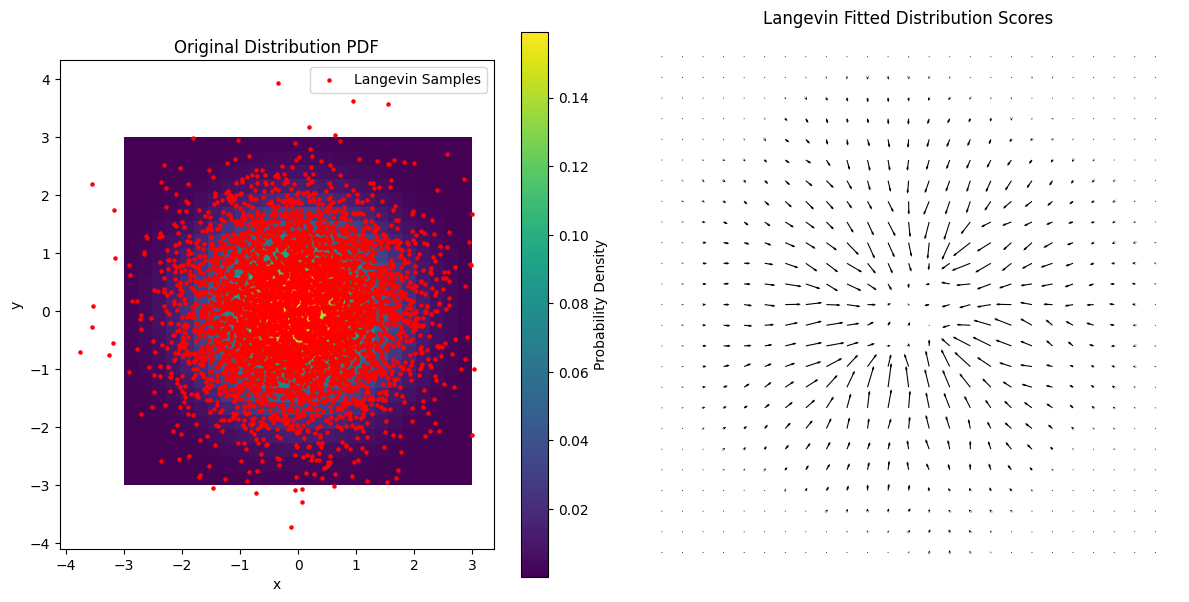

In [26]:
from scipy.stats import gaussian_kde
epsilon = 0.001  
T = 10000        
num_samples = 5000

# 执行朗之万动力学采样
x_samples = np.random.randn(num_samples, 2)
for _ in range(T):
    z_x_sample = (x_samples[:, 0] - mu_x) / sigma_x
    z_y_sample = (x_samples[:, 1] - mu_y) / sigma_y
    denom_sample = 1 - rho ** 2
    score_x = - (z_x_sample - rho * z_y_sample) / (sigma_x * denom_sample)
    score_y = - (z_y_sample - rho * z_x_sample) / (sigma_y * denom_sample)
    score = np.column_stack((score_x, score_y))
    
    z = np.random.randn(num_samples, 2)
    x_samples += (epsilon / 2) * score + np.sqrt(epsilon) * z

# 核密度估计拟合采样分布
xy = np.vstack([x_samples[:, 0], x_samples[:, 1]])
kde = gaussian_kde(xy)

# 手动计算拟合分布的梯度（数值微分）
grad_x = np.zeros_like(X)
grad_y = np.zeros_like(Y)
h = 1e-4  # 微小增量
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = np.array([X[i, j], Y[i, j]])
        
        # 计算 x 方向梯度
        point_plus_hx = point.copy()
        point_plus_hx[0] += h
        point_minus_hx = point.copy()
        point_minus_hx[0] -= h
        grad_x[i, j] = (kde(point_plus_hx) - kde(point_minus_hx)) / (2 * h)
        
        # 计算 y 方向梯度
        point_plus_hy = point.copy()
        point_plus_hy[1] += h
        point_minus_hy = point.copy()
        point_minus_hy[1] -= h
        grad_y[i, j] = (kde(point_plus_hy) - kde(point_minus_hy)) / (2 * h)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 原始分布热力图
z_x_ori = (X - mu_x) / sigma_x
z_y_ori = (Y - mu_y) / sigma_y
denom_ori = 1 - rho ** 2
exponent_ori = -0.5 / denom_ori * (z_x_ori**2 - 2 * rho * z_x_ori * z_y_ori + z_y_ori**2)
pdf_ori = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(denom_ori)) * np.exp(exponent_ori)
im = axes[0].imshow(pdf_ori, cmap='viridis', origin='lower', extent=[-3, 3, -3, 3])
axes[0].set_title('Original Distribution PDF', fontsize=12)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
fig.colorbar(im, ax=axes[0], label='Probability Density')
axes[0].scatter(x_samples[:, 0], x_samples[:, 1], c='red', s=5, label='Langevin Samples')
axes[0].legend()

# Langevin拟合分布箭头图
axes[1].quiver(X, Y, 10*grad_x, 10*grad_y, 
               scale=30, color='black', 
               width=0.002, headwidth=2, headlength=2)
axes[1].set_title('Langevin Fitted Distribution Scores', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()